In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
import datetime
import seaborn as sns
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GlobalAveragePooling1D, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, Recall, Precision, F1Score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from keras.activations import swish
from imblearn.over_sampling import SMOTE
import io
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from matplotlib.cm import Blues
from keras.models import load_model
from sklearn.metrics import confusion_matrix

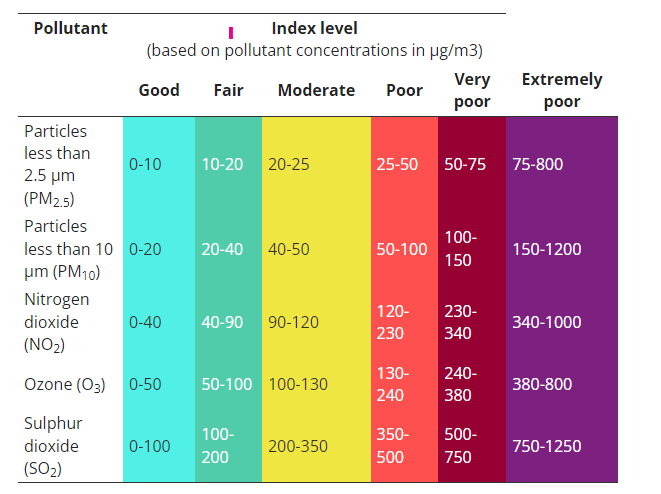

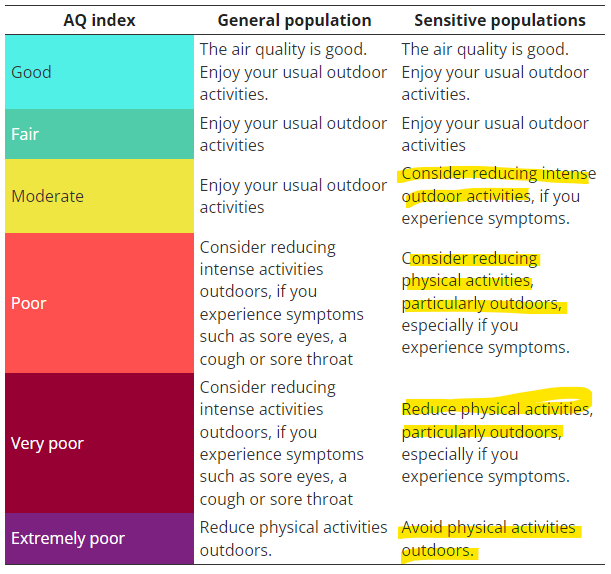

In [2]:
# Obtener la ruta base (carpeta) de este archivo
ruta_base = os.path.dirname(os.path.abspath('Prueba red neuronalLMST1'))

# Definir el nombre de la carpeta donde se encuentran los archivos CSV
nombre_carpeta = 'Basesdatos'

# Construir las rutas completas de los archivos CSV dentro de la carpeta
ruta_final_tramos = os.path.join(ruta_base, nombre_carpeta, 'df_final_tramos.xlsx')

# Cargar los archivos CSV en DataFrames
df = pd.read_excel(ruta_final_tramos)

In [3]:
# Filtrar el DataFrame 'df' para mantener solo las filas donde los valores de la columna 'PM10 (µg/m³)' son menores o iguales a 1000.
df = df[df['PM10 (µg/m³)'] <= 1000]

# Mostrar el resumen estadístico del DataFrame actualizado
df.describe()

Unnamed: 0      Estación           Año           Mes           Dia  \
count  50866.000000  50866.000000  50866.000000  50866.000000  50866.000000   
mean   25433.143357     48.366768   2020.945838      6.399088     15.724394   
std    14684.291156     17.438354      1.231630      3.392130      8.776002   
min        0.000000      4.000000   2019.000000      1.000000      1.000000   
25%    12716.250000     44.000000   2020.000000      4.000000      8.000000   
50%    25433.500000     57.000000   2021.000000      6.000000     16.000000   
75%    38149.750000     59.000000   2022.000000      9.000000     23.000000   
max    50866.000000     61.000000   2023.000000     12.000000     31.000000   

         NO (µg/m³)   NO2 (µg/m³)  PM10 (µg/m³)   NOx (µg/m³)  
count  50866.000000  50866.000000  50866.000000  50866.000000  
mean       9.791840     26.145053     22.773568     40.642338  
std       20.255170     18.261472     14.172708     44.492430  
min        0.714286      1.000000      1.000000      1.000000  
25%        1.285714     11.333333     14.000000     13.333333  
50%        3.666667     22.250000     20.142857     28.166667  
75%       11.000000     37.166667     28.166667     54.000000  
max     1071.000000    153.333333    516.000000   1676.000000

In [4]:
# Creamos columna fecha y eliminamos innecesarias para poder usar mejor el modelo

# Convertir las columnas de "Año", "Mes" y "Dia" en cadenas (strings) para poder combinarlas y formar la columna "fecha".
df['Año'] = df['Año'].astype(str)
df['Mes'] = df['Mes'].astype(str)
df['Dia'] = df['Dia'].astype(str)

# Concatenar las columnas de "Año", "Mes" y "Dia" para formar la columna "fecha" en formato "YYYY-MM-DD".
df['Fecha'] = df['Año'] + "-" + df['Mes'] + "-" + df['Dia']

# Convertir la columna "fecha" al tipo de dato datetime para trabajar con fechas.
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Eliminamos columnas que no necesitamos
df = df.drop(['Unnamed: 0','Longitud','Latitud', 'Año', 'Mes', 'Dia'], axis=1)

# Imprimir DataFrame 
df.head()

Estación Horario_Categoria  NO (µg/m³)  NO2 (µg/m³)  PM10 (µg/m³)  \
0         4            mañana   63.833333    83.000000     69.666667   
1         4          mediodía   14.000000    55.000000     72.666667   
2         4             noche    1.285714    38.428571     25.285714   
3         4             tarde    6.250000    51.000000     86.750000   
4         4            mañana    4.000000    29.000000     23.000000   

   NOx (µg/m³)      Fecha  
0   180.666667 2019-04-02  
1    77.000000 2019-04-02  
2    40.000000 2019-04-02  
3    60.500000 2019-04-02  
4    34.500000 2019-04-03

In [5]:
# Creamos columna primer confinamiento para distinguir valores atípicos

df['Covid-confinamiento1'] = False
df['Covid-confinamiento2'] = False

# Marcamos fecha de inicio y fin del periodo
fecha_inicio = '2020-03-15'
fecha_fin = '2020-06-21'

# Modificamos valores de la tabla con intervalo especificado
df.loc[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin), 'Covid-confinamiento1'] = True

# Creamos columna segundo confinamiento para distinguir valores atípicos

# Marcamos fecha de inicio y fin del periodo
fecha_inicio = '2020-10-25'
fecha_fin = '2021-05-09'

# Modificamos valores de la tabla con intervalo especificado
df.loc[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin), 'Covid-confinamiento2'] = True

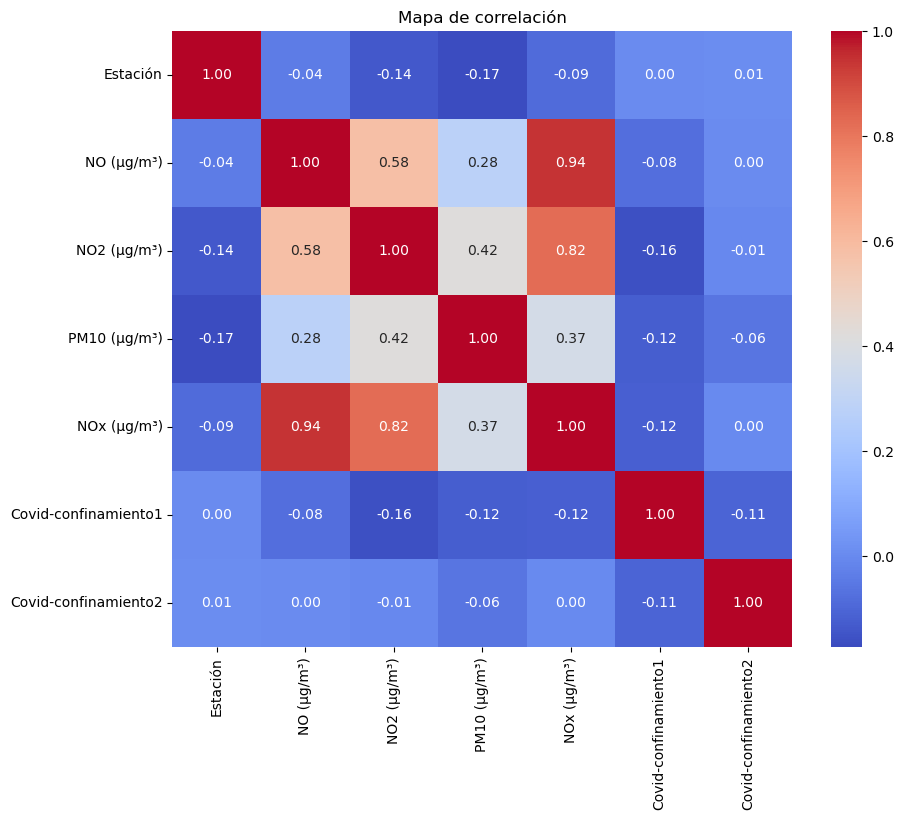

In [6]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Visualizar el mapa de correlación utilizando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de correlación")
plt.show()

In [7]:
# Ordenar los datos por fecha y hora
df.sort_values(by='Fecha', inplace=True)

# Extraer las componentes año, mes, día y hora
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Dia'] = df['Fecha'].dt.day

# Eliminamos columnas que no necesitamos
df= df.drop(['NOx (µg/m³)', 'NO (µg/m³)','Fecha'], axis=1)

# Crear e imprimir DataFrame
df = pd.DataFrame(df)
df.head()

Estación Horario_Categoria  NO2 (µg/m³)  PM10 (µg/m³)  \
0             4            mañana    83.000000     69.666667   
17725        54          mediodía    20.333333     40.333333   
17724        54            mañana    82.166667     42.333333   
23482        57            mañana    73.166667     36.333333   
23483        57          mediodía    17.333333     38.833333   

       Covid-confinamiento1  Covid-confinamiento2   Año  Mes  Dia  
0                     False                 False  2019    4    2  
17725                 False                 False  2019    4    2  
17724                 False                 False  2019    4    2  
23482                 False                 False  2019    4    2  
23483                 False                 False  2019    4    2

In [8]:
# Definir las categorías y los intervalos para PM10 y NO2
pm10_categories = ['Perfecto', 'Buena', 'Regular','Desfavorable',]
pm10_intervals = [0, 25, 40, 70]

no2_categories = ['Perfecto','Buena','Regular','Desfavorable']
no2_intervals = [0, 35, 85, 250, 700]

# Función para clasificar los valores en función de los intervalos
def classify_pollutant(value, intervals, categories):
    for i in range(len(intervals) - 1):
        if intervals[i] <= value < intervals[i + 1]:
            return categories[i]
    return categories[-1]

# Aplicar la clasificación para PM10 y NO2 y crear nuevas columnas en el DataFrame
df['PM10_Index_level'] = df['PM10 (µg/m³)'].apply(lambda x: classify_pollutant(x, pm10_intervals, pm10_categories))
df['NO2_Index_level'] = df['NO2 (µg/m³)'].apply(lambda x: classify_pollutant(x, no2_intervals, no2_categories))

In [9]:
# Contar valores e imprimir en 'PM10_Index_level'
counts = df['PM10_Index_level'].value_counts()
print(counts)

Perfecto        33840
Buena           12735
Regular          3752
Desfavorable      539
Name: PM10_Index_level, dtype: int64


In [10]:
# Crear nuevo DataFrame sin la columna PM10
df_NN1=df.drop(columns = ['PM10 (µg/m³)'], axis = 1)

# Imprimir nuevo DataFrame
df_NN1.head()

Estación Horario_Categoria  NO2 (µg/m³)  Covid-confinamiento1  \
0             4            mañana    83.000000                 False   
17725        54          mediodía    20.333333                 False   
17724        54            mañana    82.166667                 False   
23482        57            mañana    73.166667                 False   
23483        57          mediodía    17.333333                 False   

       Covid-confinamiento2   Año  Mes  Dia PM10_Index_level NO2_Index_level  
0                     False  2019    4    2          Regular           Buena  
17725                 False  2019    4    2          Regular        Perfecto  
17724                 False  2019    4    2          Regular           Buena  
23482                 False  2019    4    2            Buena           Buena  
23483                 False  2019    4    2            Buena        Perfecto

In [11]:
# Preparar los datos para el modelo LSTM
n_steps = 100  # Tamaño de la secuencia de entrada (48 horas)

# Filtrar y preparar los datos para el índice PM10
df_pm10 = df_NN1[['Estación', 'PM10_Index_level', 'Año', 'Mes', 'Dia', 'Horario_Categoria', 'Covid-confinamiento1', 'Covid-confinamiento2', 'NO2 (µg/m³)']].copy()
df_pm10.dropna(inplace=True)  # Eliminar filas con valores faltantes

# Codificar las estaciones de medición
df_pm10['Estación'] = LabelEncoder().fit_transform(df_pm10['Estación']) + 1

# Convertir la columna "Estación" en variables dummy
df_pm10 = pd.get_dummies(df_pm10, columns=['Estación'])
df_pm10 = pd.get_dummies(df_pm10, columns=['Horario_Categoria'])
df_pm10 = pd.get_dummies(df_pm10, columns=['Año'])
df_pm10 = pd.get_dummies(df_pm10, columns=['Mes'])
df_pm10 = pd.get_dummies(df_pm10, columns=['Dia'])

# Codificar la columna "PM10_Index_level" a valores numéricos
df_pm10['PM10_Index_level'] = df_pm10['PM10_Index_level'].astype('category').cat.codes

# Normalizar solo las variables numéricas relevantes
scaler = MinMaxScaler()
df_pm10[['Covid-confinamiento1', 'Covid-confinamiento2', 'NO2 (µg/m³)']] = scaler.fit_transform(df_pm10[['Covid-confinamiento1', 'Covid-confinamiento2', 'NO2 (µg/m³)']])

# Dividir los datos en conjuntos de entrada y salida
X = df_pm10.drop('PM10_Index_level', axis=1).values
y = df_pm10['PM10_Index_level'].values

# Aplicar SMOTE para equilibrar las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convertir y_resampled a one-hot encoding
y_resampled_onehot = pd.get_dummies(y_resampled).values

In [12]:
# Convertir y a one-hot encoding
y_onehot = pd.get_dummies(df_pm10['PM10_Index_level']).values

# Asegurarse de que X y y tengan la misma cantidad de muestras
y = y[n_steps:]

In [13]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

# Convertir y_train a float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
# Crear un modelo secuencial
RNN_Model2 = Sequential()

# Añadir una capa GRU al modelo con 64 unidades y la función de activación 'swish'
RNN_Model2.add(GRU(units=64, activation=swish, input_shape=(None, 1)))

# Añadir una capa Dropout al modelo con una tasa de 0.5 (50% de dropout)
RNN_Model2.add(Dropout(0.5))

# Aplanar los datos para que puedan ser conectados a una capa densa
RNN_Model2.add(Flatten())

# Añadir una capa densa al modelo con 4 unidades y la función de activación 'softmax'
RNN_Model2.add(Dense(units=4, activation='softmax'))

In [15]:
# Compilar el modelo con Adagrad
RNN_Model2.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.F1Score(name='f1_score')])

In [21]:
# Definir callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar el modelo con los callbacks y class weights
history2 = RNN_Model2.fit(X_train, y_train, epochs=300, batch_size=80, validation_split=0.25, callbacks=[early_stop, reduce_lr])


Epoch 1/5
1016/1016 [==============================] - 26s 25ms/step - loss: 1.2358 - accuracy: 0.4207 - precision: 0.6203 - recall: 0.1244 - f1_score: 0.3920 - val_loss: 1.1994 - val_accuracy: 0.4441 - val_precision: 0.6344 - val_recall: 0.1607 - val_f1_score: 0.4047 - lr: 0.0010
Epoch 2/5
1016/1016 [==============================] - 25s 25ms/step - loss: 1.2010 - accuracy: 0.4396 - precision: 0.6429 - recall: 0.1586 - f1_score: 0.4164 - val_loss: 1.1649 - val_accuracy: 0.4632 - val_precision: 0.6906 - val_recall: 0.1652 - val_f1_score: 0.4457 - lr: 0.0010
Epoch 3/5
1016/1016 [==============================] - 25s 25ms/step - loss: 1.1813 - accuracy: 0.4560 - precision: 0.6504 - recall: 0.1784 - f1_score: 0.4372 - val_loss: 1.1578 - val_accuracy: 0.4634 - val_precision: 0.7066 - val_recall: 0.1777 - val_f1_score: 0.4502 - lr: 0.0010
Epoch 4/5
1016/1016 [==============================] - 26s 25ms/step - loss: 1.1615 - accuracy: 0.4657 - precision: 0.6602 - recall: 0.1943 - f1_score: 0.

In [18]:
# Cargar el modelo desde el archivo HDF5
modelo_cargado = load_model('modelobueno2.keras')

846/846 [==============================] - 4s 4ms/step


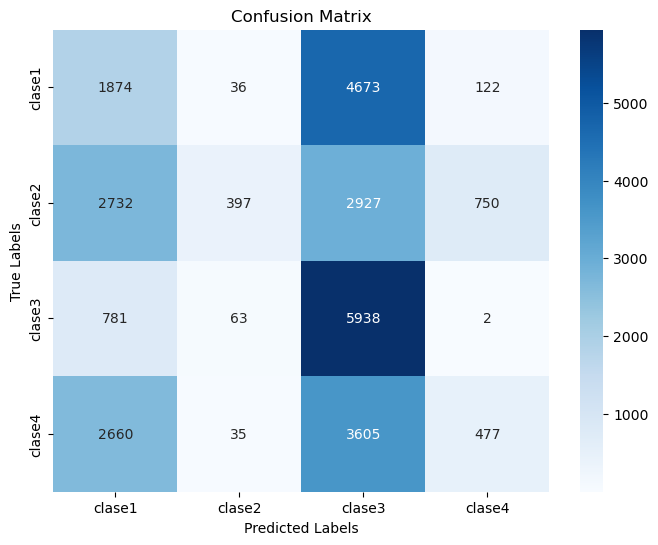

In [19]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_cargado.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Crear la matriz de confusión usando el método confusion_matrix de scikit-learn
confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Obtener las etiquetas de las clases para visualizar la matriz
classes = ['clase1', 'clase2', 'clase3', 'clase4']  # Reemplaza con las etiquetas de tus clases

# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

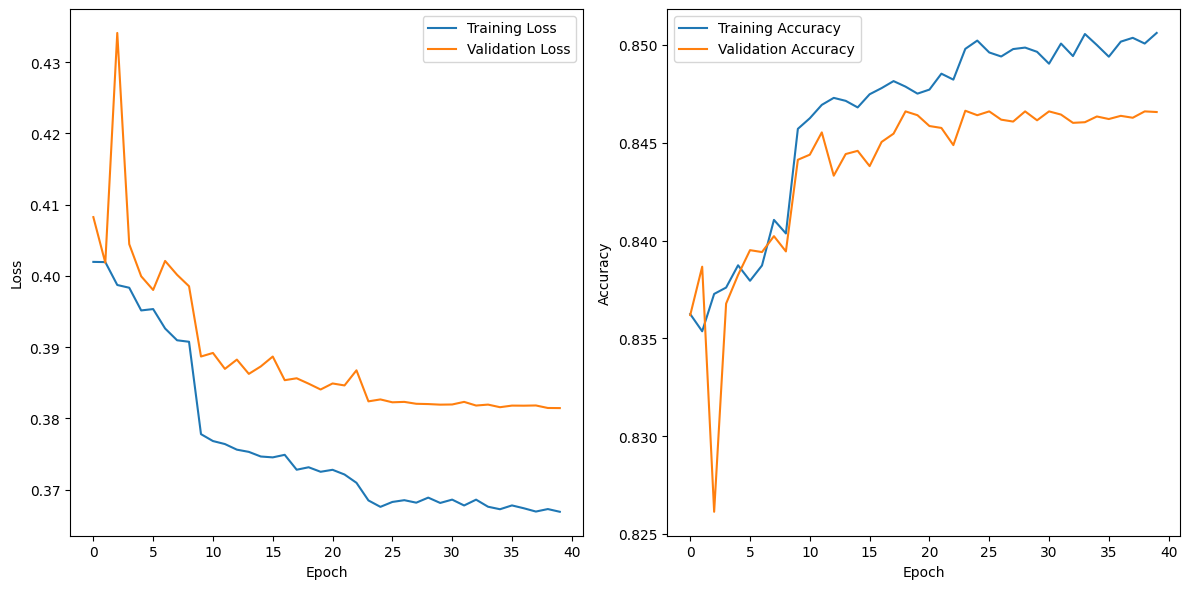

In [177]:
# Plot Loss y Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()